# Download data

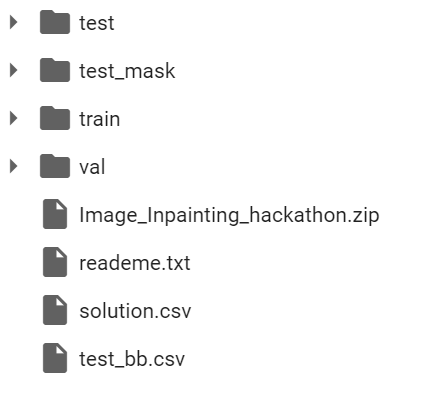

In [11]:
# prompt: create a function to randomly put a black box size 7*7 inside the given gray scale image then return the processed image and the mask.

import numpy as np
def create_masked_image(image):
  """
  Randomly puts a black box of size 7x7 inside the given grayscale image.

  Args:
    image: A NumPy array representing a grayscale image.

  Returns:
    A tuple containing:
      - The processed image with the black box.
      - The corresponding mask with 1s where the box is and 0s elsewhere.
  """

  # Create a copy of the image to avoid modifying the original.
  processed_image = image.copy()

  # Generate random coordinates for the top-left corner of the box.
  x = np.random.randint(0, image.shape[0] - 7)
  y = np.random.randint(0, image.shape[1] - 7)

  # Create the black box on the processed image.
  processed_image[x:x+7, y:y+7] = 0

  # Create the mask.
  mask = np.zeros_like(image)
  mask[x:x+7, y:y+7] = 1

  return processed_image, mask


In [12]:
# prompt: create Dataset to load image from a given folder preprocess with function create_masked_image() and a given transformation then return image, processed image and mask

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class ImageInpaintingDataset(Dataset):
  def __init__(self, image_dir, transform=None):
    self.image_dir = image_dir
    self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]
    self.transform = transform

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, idx):
    img_path = os.path.join(self.image_dir, self.image_files[idx])
    image = Image.open(img_path).convert('L')  # Convert to grayscale

    if self.transform:
      image = self.transform(image)

    processed_image, mask = create_masked_image(np.array(image))

    # Convert to PyTorch tensors
    image = transforms.ToTensor()(image)
    processed_image = transforms.ToTensor()(processed_image)
    mask = transforms.ToTensor()(mask)

    return image, processed_image, mask

# Example usage:
transform = transforms.Compose([
    # transforms.Resize((256, 256))
    # Add other transformations as needed
])


In [13]:
# prompt: create data loader from /content/train, and /content/val in parallel by automatically get appropriate number of cpu core

import multiprocessing

# Get the number of CPU cores
num_workers = multiprocessing.cpu_count()

# Create datasets
train_dataset = ImageInpaintingDataset('/kaggle/input/missing-pieces-the-ai-image-completion/train', transform=transform)
val_dataset = ImageInpaintingDataset('/kaggle/input/missing-pieces-the-ai-image-completion/test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=num_workers)


# GAN Model

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.adjust_channels = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.adjust_channels is not None:
            residual = self.adjust_channels(residual)
        out += residual
        out = self.relu(out)
        return out

# Self-Attention Mechanism
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        query = self.query(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        key = self.key(x).view(batch_size, -1, width * height)
        energy = torch.bmm(query, key)
        attention = F.softmax(energy, dim=-1)
        value = self.value(x).view(batch_size, -1, width * height)
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, channels, height, width)
        out = self.gamma * out + x
        return out

# UNET Generator with Residual Blocks, Self-Attention and Spectral Normalization
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        def conv_block(in_channels, out_channels, use_bn=True):
            layers = [ResidualBlock(in_channels, out_channels)]
            if use_bn:
                layers.append(nn.BatchNorm2d(out_channels))
            return nn.Sequential(*layers)
        
        def up_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                nn.LeakyReLU(0.2, inplace=True)
            )
        
        # Encoder
        self.enc1 = conv_block(1, 64, use_bn=False)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        
        # Attention Layer (before bottleneck)
        self.attention = SelfAttention(512)

        # Bottleneck
        self.bottleneck = conv_block(512, 1024)
        
        # Decoder
        self.up4 = up_conv(1024, 512)
        self.dec4 = conv_block(1024, 512)
        self.up3 = up_conv(512, 256)
        self.dec3 = conv_block(512, 256)
        self.up2 = up_conv(256, 128)
        self.dec2 = conv_block(256, 128)
        self.up1 = up_conv(128, 64)
        self.dec1 = conv_block(128, 64, use_bn=False)
        
        # Output
        self.out = nn.Conv2d(64, 1, kernel_size=1)
        self.tanh = nn.Tanh()  # Output pixel values in range [-1, 1]

        # Spectral Normalization
        self.apply_spectral_norm()

    def apply_spectral_norm(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d):
                nn.utils.spectral_norm(module)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(nn.MaxPool2d(2)(enc1))
        enc3 = self.enc3(nn.MaxPool2d(2)(enc2))
        enc4 = self.enc4(nn.MaxPool2d(2)(enc3))
        
        # Attention
        enc4 = self.attention(enc4)
        
        # Bottleneck
        bottleneck = self.bottleneck(nn.MaxPool2d(2)(enc4))
        
        # Decoder
        dec4 = self.up4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        dec3 = self.up3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        dec2 = self.up2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        dec1 = self.up1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        
        # Output
        out = self.out(dec1)
        return self.tanh(out)

# Improved Discriminator with Residual Blocks and Dropout
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            ResidualBlock(64, 128),
            nn.Dropout(0.3),
            nn.utils.spectral_norm(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            ResidualBlock(256, 512),
            nn.Dropout(0.3),
            nn.utils.spectral_norm(nn.Conv2d(512, 1, kernel_size=4, padding=0)),
            nn.Sigmoid()  # Output probability of real image
        )

    def forward(self, x):
        return self.model(x)


# Training

In [15]:
def train(generator, discriminator, train_loader, val_loader, num_epochs, criterion_gan, criterion_pixelwise, optimizer_g, optimizer_d, device):
    """
    Trains the generator and discriminator models.

    Args:
        generator: The generator model.
        discriminator: The discriminator model.
        train_loader: DataLoader for the training dataset.
        val_loader: DataLoader for the validation dataset.
        num_epochs: Number of epochs to train for.
        criterion_gan: Loss function for the GAN (e.g., Binary Cross Entropy).
        criterion_pixelwise: Loss function for pixel-wise reconstruction (e.g., L1 loss).
        optimizer_g: Optimizer for the generator.
        optimizer_d: Optimizer for the discriminator.
        device: Device to run the training on (e.g., 'cuda' or 'cpu').
    """

    best_val_loss = float('inf')
    patience = 10  # Number of epochs to wait for improvement
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()
        train_loss_g = 0
        train_loss_d = 0

        for batch_idx, (original_images, masked_images, masks) in enumerate(train_loader):
            original_images = original_images.to(device)
            masked_images = masked_images.to(device)
            masks = masks.to(device)

            # Train Discriminator
            optimizer_d.zero_grad()
            # Real images
            real_outputs = discriminator(original_images)
            real_loss = criterion_gan(real_outputs, torch.ones_like(real_outputs))
            # Generated images
            generated_images = generator(masked_images)
            fake_outputs = discriminator(generated_images.detach())  # Detach to avoid training generator here
            fake_loss = criterion_gan(fake_outputs, torch.zeros_like(fake_outputs))
            # Total discriminator loss
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer_d.step()
            train_loss_d += loss_d.item()

            # Train Generator
            optimizer_g.zero_grad()
            # Adversarial loss
            fake_outputs = discriminator(generated_images)
            loss_gan = criterion_gan(fake_outputs, torch.ones_like(fake_outputs))
            # Pixel-wise reconstruction loss
            loss_pixelwise = criterion_pixelwise(generated_images, original_images)
            # Total generator loss
            loss_g = loss_gan + loss_pixelwise
            loss_g.backward()
            optimizer_g.step()
            train_loss_g += loss_g.item()

        # Calculate average training losses
        train_loss_g /= len(train_loader)
        train_loss_d /= len(train_loader)

        # Validation
        generator.eval()
        discriminator.eval()
        val_loss = 0
        with torch.no_grad():
            for original_images, masked_images, masks in val_loader:
                original_images = original_images.to(device)
                masked_images = masked_images.to(device)
                masks = masks.to(device)

                generated_images = generator(masked_images)
                loss_pixelwise = criterion_pixelwise(generated_images, original_images)
                val_loss += loss_pixelwise.item()

        val_loss /= len(val_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss G: {train_loss_g:.4f}, Train Loss D: {train_loss_d:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            # Save the best model (optional)
            # torch.save(generator.state_dict(), 'best_generator.pth')
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping triggered.")
                break


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = Generator().to(device)
generator = torch.nn.DataParallel(generator)
discriminator = Discriminator().to(device)
discriminator = torch.nn.DataParallel(discriminator)

# Loss functions
criterion_gan = nn.BCELoss()
criterion_pixelwise = nn.L1Loss()

# Optimizers
optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Train the model
train(generator, discriminator, train_loader, val_loader, num_epochs=200,
      criterion_gan=criterion_gan, criterion_pixelwise=criterion_pixelwise,
      optimizer_g=optimizer_g, optimizer_d=optimizer_d, device=device)


Epoch [1/200] Train Loss G: 1.3448, Train Loss D: 1.4151, Val Loss: 0.0777
Epoch [2/200] Train Loss G: 0.7924, Train Loss D: 1.4464, Val Loss: 0.0473
Epoch [3/200] Train Loss G: 0.7498, Train Loss D: 1.4176, Val Loss: 0.0406
Epoch [4/200] Train Loss G: 0.7386, Train Loss D: 1.4081, Val Loss: 0.0325
Epoch [5/200] Train Loss G: 0.7327, Train Loss D: 1.4004, Val Loss: 0.0291
Epoch [6/200] Train Loss G: 0.7273, Train Loss D: 1.3959, Val Loss: 0.0266
Epoch [7/200] Train Loss G: 0.7274, Train Loss D: 1.3948, Val Loss: 0.0257
Epoch [8/200] Train Loss G: 0.7225, Train Loss D: 1.3934, Val Loss: 0.0302
Epoch [9/200] Train Loss G: 0.7256, Train Loss D: 1.3916, Val Loss: 0.0253
Epoch [10/200] Train Loss G: 0.7182, Train Loss D: 1.3904, Val Loss: 0.0219
Epoch [11/200] Train Loss G: 0.7190, Train Loss D: 1.3897, Val Loss: 0.0278
Epoch [12/200] Train Loss G: 0.7181, Train Loss D: 1.3896, Val Loss: 0.0187
Epoch [13/200] Train Loss G: 0.7204, Train Loss D: 1.3891, Val Loss: 0.0187
Epoch [14/200] Train 

# Inference

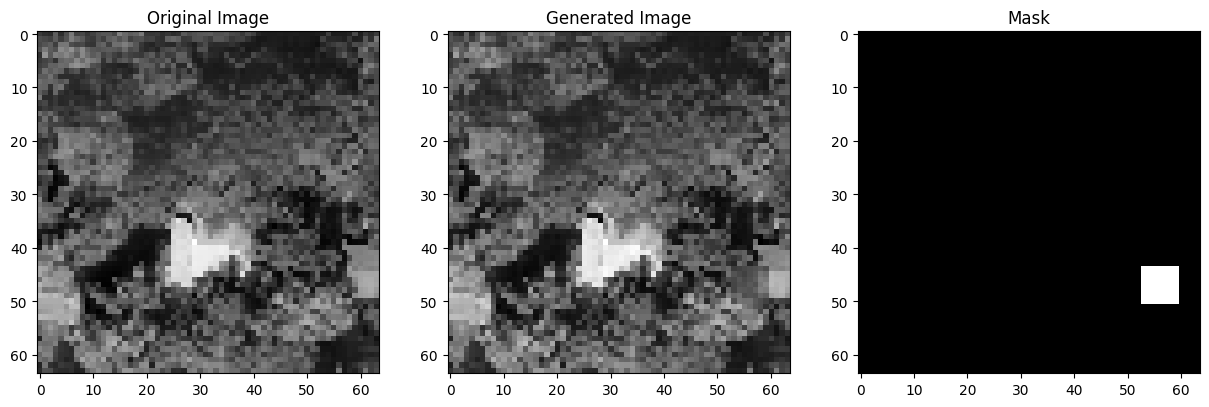

MSE Loss at Masked Area: 0.0000


In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/kaggle/input/missing-pieces-the-ai-image-completion/val/img0002.png'
image = Image.open(image_path).convert('L')  # Convert to grayscale

# Apply transformations (if any)
if transform:
    image = transform(image)

# Create masked image
processed_image, mask = create_masked_image(np.array(image))

# Convert to PyTorch tensors
image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)  # Add batch dimension
processed_image_tensor = transforms.ToTensor()(processed_image).unsqueeze(0).to(device)
mask_tensor = transforms.ToTensor()(mask).unsqueeze(0).to(device)

# Generate the completed image
generator.eval()
with torch.no_grad():
    generated_image_tensor = generator(processed_image_tensor)

# Calculate MSE loss at the masked area
mse_loss = nn.MSELoss()(generated_image_tensor * mask_tensor, image_tensor * mask_tensor)

# Convert tensors to NumPy arrays for plotting
original_image = image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
generated_image = generated_image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
mask_array = mask_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(generated_image, cmap='gray')
axes[1].set_title('Generated Image')
axes[2].imshow(mask_array, cmap='gray')
axes[2].set_title('Mask')
plt.show()

print(f"MSE Loss at Masked Area: {mse_loss.item():.4f}")


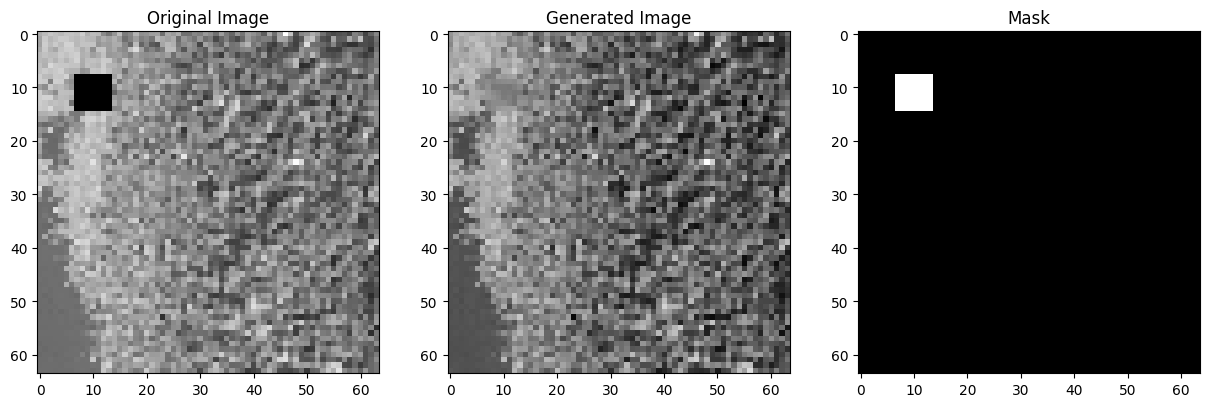

MSE Loss at Masked Area: 0.0020


In [23]:
import matplotlib.pyplot as plt
# Load the image
image_path = '/kaggle/input/missing-pieces-the-ai-image-completion/test/img0003.png'
image = Image.open(image_path).convert('L')  # Convert to grayscale

# Load the mask
mask_path = '/kaggle/input/missing-pieces-the-ai-image-completion/test_mask/img0003.png'
mask = Image.open(mask_path).convert('L')

# Apply transformations (if any)
# if transform:
#     image = transform(image)
#     mask = transform(mask)

# Convert to PyTorch tensors
image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)  # Add batch dimension
mask_tensor = transforms.ToTensor()(mask).unsqueeze(0).to(device)

# Create a masked image (black out the masked area)
processed_image_tensor = image_tensor * (1 - mask_tensor)

# Generate the completed image
generator.eval()
with torch.no_grad():
    generated_image_tensor = generator(processed_image_tensor)

# Calculate MSE loss at the masked area
mse_loss = nn.MSELoss()(generated_image_tensor * mask_tensor, image_tensor * mask_tensor)

# Convert tensors to NumPy arrays for plotting
original_image = image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
generated_image = generated_image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
mask_array = mask_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(generated_image, cmap='gray')
axes[1].set_title('Generated Image')
axes[2].imshow(mask_array, cmap='gray')
axes[2].set_title('Mask')
plt.show()

print(f"MSE Loss at Masked Area: {mse_loss.item():.4f}")



# Submission

In [25]:
import pandas as pd

# Load bounding box data
bb_df = pd.read_csv('/kaggle/input/missing-pieces-the-ai-image-completion/test_mask.csv')

# Prepare output list
output_data = []

# Loop through test images
for index, row in bb_df.iterrows():
    img_path = row['img_path']
    top = int(row['top'])
    left = int(row['left'])  # Assuming 'left' column exists

    # Load masked image and mask
    masked_image_path = os.path.join('/kaggle/input/missing-pieces-the-ai-image-completion/test', img_path)
    mask_path = os.path.join('/kaggle/input/missing-pieces-the-ai-image-completion/test_mask', img_path)
    masked_image = Image.open(masked_image_path).convert('L')
    mask = Image.open(mask_path).convert('L')

    # Apply transformations (if any)
    if transform:
        masked_image = transform(masked_image)
        mask = transform(mask)

    # Convert to PyTorch tensors
    masked_image_tensor = transforms.ToTensor()(masked_image).unsqueeze(0).to(device)
    mask_tensor = transforms.ToTensor()(mask).unsqueeze(0).to(device)

    # Generate the completed image
    generator.eval()
    with torch.no_grad():
        generated_image_tensor = generator(masked_image_tensor)

    # Extract pixel values within the bounding box
    generated_image_np = generated_image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    for i in range(top, top + 7):
        for j in range(left, left + 7):
            intensity = generated_image_np[i, j, 0] * 255  # Scale to [0, 255]
            file_id = img_path.split('.')[0] + f'_{i}_{j}'
            output_data.append([file_id, intensity])

# Create DataFrame and save to CSV
output_df = pd.DataFrame(output_data, columns=['ID', 'Value'])
output_df.to_csv('submission.csv', index=False)
